In [1]:
import sys
sys.path.append('python/')

import time
startTime = time.time()

import numpy as np
import matplotlib.pyplot as plt 
import load_galaxies as lg
import matplotlib.image as mpimg
import lmfit as lm

## Import data

In [2]:
galaxy = lg.NGC5533                  # Choose your galaxy

# Measured data
measured_data = galaxy['measured_data']

# Separate the columns into arrays
m_radii = galaxy['m_radii']
m_velocities = galaxy['m_velocities']
m_r_errors = galaxy['m_r_errors']
m_v_errors = galaxy['m_v_errors']    # Errors in velocity

# Central black hole
massbh = galaxy['massbh']           # Mass of the central black hole in (solar mass)
G = 4.300e-6                        # Gravitational constant (kpc/solar mass*(km/s)^2)
def blackhole_v(r,massbh):
    return np.sqrt((G*massbh)/r)

# Bulge
bulge_v = galaxy['bulge']['spline']
# Disk
disk_v = galaxy['disk']['spline']
# Gas
gas_v = galaxy['gas']['spline']
# Dark matter halo
halo_v = galaxy['halo']['spline']
# Total velocity
total_v = galaxy['total']['spline']

## Calculate dark matter halo component (bonus)

In [3]:
# Set parameters
rho0 = galaxy['rho0']   # central mass density (in solar mass/kpc^3)
rc = galaxy['rc']       # core radius (in kpc)

# Equation for dark matter halo velocity
def halo_v_calc(r,rho0,rc):
    v = np.sqrt(4*np.pi*G*rho0*rc**2*(1 - rc/r * np.arctan(r/rc)))
    return v

## Define some values

In [4]:
# Express weight
weighdata = 1/m_v_errors

# Define function for total velocity with prefactors
def total_v_pref(r,massbh,bpref,dpref,gpref,hpref):
    return np.sqrt(blackhole_v(r,massbh)**2
                   + (bpref*bulge_v(r))**2 
                   + (dpref*disk_v(r))**2 
                   + (gpref*gas_v(r))**2
                   + (hpref*halo_v(r))**2)

# Define function for total velocity with prefactors, using the calculated DM velocity with two free parameters: rho0, rc
def total_v_pref_2freeDM(r,massbh,bpref,dpref,gpref,rho0,rc):
    return np.sqrt(blackhole_v(r,massbh)**2
                   + (bpref*bulge_v(r))**2 
                   + (dpref*disk_v(r))**2 
                   + (gpref*gas_v(r))**2
                   + (halo_v(r,rho0,rc)**2))

## Fitting parameters

Parameters can be varied during the fit. Turn these off and on to see how your results of the fit changes. 

In [5]:
# Setup 
f_mod = lm.Model(total_v_pref)
f_params = f_mod.make_params()

# Setup with calculated DM velocity
#f_mod = lm.Model(total_v_pref_2freeDM)
#f_params = f_mod.make_params()

# Halo
f_params.add('hpref',    vary=True,    value=1,   min=0.1)      # halo prefactor

# Halo (using the calculated halo velocity with two free parameters)
#f_params.add('rc',      vary=True,     value=rc,   min=0.1)     # core radius (kpc)
#f_params.add('rho0',    vary=True,     value=rho0, min=0)       # central halo density (solar mass/kpc^3)

# Black Hole
f_params.add('massbh',  vary=False,    value=massbh, min=1.0e8)   # mass of central black hole

# Bulge
f_params.add('bpref',   vary=False,    value=1,   min=0,max=100)  # bulge prefactor

# Disk
f_params.add('dpref',   vary=False,    value=1,   min=0,max=100)  # disk prefactor

# Gas
f_params.add('gpref',   vary=False,    value=1,   min=.8,max=1.2) # gas prefactor

## Do the fitting

In [6]:
f_fit = f_mod.fit(m_velocities,f_params,r=m_radii,weights=weighdata)

# Show fit statistics
f_fit

### $\chi^2$ (Chi-squared):

The chi-squared value is an indication of the goodness of your fit or how well the observed and expected data agree. A zero chi-squared value would mean a perfect fit which is highly unlikely. The expected value of chi-squared is the number of degrees of freedom or "the number of observed points minus the number of parameters computed from the data and used in the calculation" (Taylor, 1997).


### Reduced chi-squared
The reduced chi-squared value is the chi-squared value divided by the degree of freedom. In general, we would want this value to be close to 1 to be a good fit. 

## Define parameters for plotting

In [7]:
bestf = f_fit.best_fit

# Radius
r = np.linspace(0.01,100,100)        # starting from zero results in a divide by zero error

f_dict = f_fit.best_values
f_hpref = f_dict['hpref']
f_massbh = f_dict['massbh']
f_bpref = f_dict['bpref']
f_dpref = f_dict['dpref']
f_gpref = f_dict['gpref']

f_curve = total_v_pref(r,f_massbh,f_bpref,f_dpref,f_gpref,f_hpref)

# For the calculated halo velocity with two free parameters
#f_rc = f_dict['rc']
#f_rho0 = f_dict['rho0']
#f_curve = total_v_pref_2freeDM(r,f_massbh,f_bpref,f_dpref,f_gpref,f_rho0,f_rc)

## Plot result

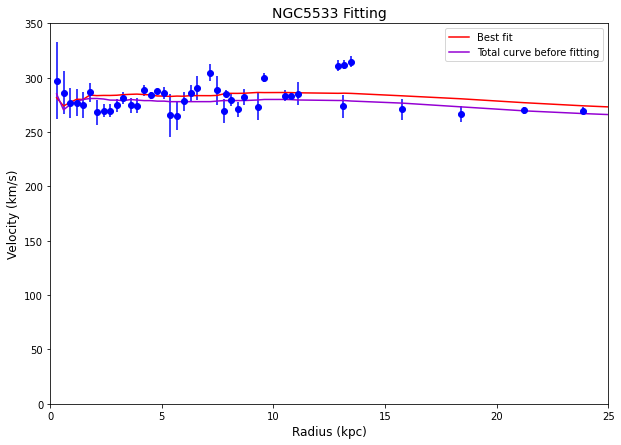

In [8]:
plt.figure(figsize=(10.0,7.0))                                     # size of the plot
plt.errorbar(m_radii,m_velocities,yerr=m_v_errors,fmt='bo')
plt.plot(m_radii,bestf, color='r', label='Best fit')
plt.plot(m_radii,total_v(m_radii), color='darkviolet', label='Total curve before fitting')
plt.title('NGC{} Fitting'.format(galaxy['galaxyname']), fontsize=14)     # giving the plot a title
plt.xlabel('Radius (kpc)', fontsize=12)                           # labeling the x-axis
plt.ylabel('Velocity (km/s)', fontsize=12)                        # labeling the y-axis
plt.xlim(0,25)
plt.ylim(0,350)
plt.legend(loc="upper right")
plt.show()

## Calculate the total mass of the dark matter (bonus)

In [9]:
import scipy.integrate as si             # for integration

# Equation for isothermal density
def density_iso(r,rho0,rc):
    density = rho0 * (1 + (r/rc)**2)**(-1)
    return density

# Equation for mass as a function of radius
def mass_function(r,rho0,rc):
    mass = 4 * np.pi * density_iso(r,rho0,rc) * r**2
    return mass

# Integrate to calculate total mass enclosed
totalmass = lambda r,rho0,rc: si.quad(mass_function, 0, r, args=(rho0,rc))[0]

# Radius at which we are calculating the total mass enclosed
radius = 25   # in kpc

# Total mass
print("Total mass of the dark matter between 0 and {} kpc is {:.3e} solar masses.".format(radius,totalmass(radius,rho0,rc)))

Total mass of the dark matter between 0 and 25 kpc is 1.747e+11 solar masses.


In [10]:
# Time
executionTime = (time.time() - startTime)
ttt=executionTime/60
print(f'Execution time: {ttt:.2f} minutes')

Execution time: 0.03 minutes


# References <br>
>Casertano, Stefano. __"Rotation curve of the edge-on spiral galaxy NGC 5907: disc and halo masses."__ _Monthly Notices of the Royal Astronomical Society_ 203, no. 3 (1983): 735-747.<br><br>
>Jimenez, Raul, Licia Verde, and S. Peng Oh. __"Dark halo properties from rotation curves."__ _Monthly Notices of the Royal Astronomical Society_ 339, no. 1 (2003): 243-259.<br><br>
>Karukes, E. V., P. Salucci, and Gianfranco Gentile. __"The dark matter distribution in the spiral NGC 3198 out to 0.22 $R_{vir}$."__ _Astronomy & Astrophysics_ 578 (2015): A13.<br><br>
>Noordermeer, Edo. __"The rotation curves of flattened Sérsic bulges."__ _Monthly Notices of the Royal Astronomical Society_ 385, no. 3 (2007): 1359-1364.<br><br>
>Taylor, John Robert. __An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements.__ 2nd ed. United States of America: University Science Books, 1997. 
***